<a href="https://colab.research.google.com/github/nvalsangkar/Waterline-Jamuna/blob/main/WaterlineJamuna_Sentinel1_WaterDelineation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is provided as supplementary material to the manuscript *Combining Earth Observations with Ground Data to Assess River Topography and Morphologic Change: Case Study of the Lower Jamuna River*, submitted to International Journal of Applied Earth Observations and Geoinformation, 2024. Authors: N. Valsangkar, A. Nelson, and Md. F. Hassan.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [2]:
# Import libraries
#!pip install ipyleaflet==0.18.2
# %pip install -U geemap

import ee
import geemap
import os
import geemap.chart as chart
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np

In [4]:
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
# Ensure Earth Engine API is enabled in Google Cloud.
# https://console.cloud.google.com/
ee.Initialize(project='YOUR PROJECT ID')

In [9]:
#  Define region of interest (roi)
Map=geemap.Map()
roi = ee.Geometry.Rectangle(89.6206, 24.4842, 89.85,  23.769174)
Map.centerObject(roi,8)
Map.addLayer(roi, name='ROI')
Map

Map(center=[24.126396779641777, 89.73529999999927], controls=(WidgetControl(options=['position', 'transparent_…

In [6]:
# Refined Lee speckle filter preprocessor from Mulissa et al, 2021, code adapted from: https://github.com/adugnag/gee_s1_ard/blob/main/python-api/speckle_filter.py

def lin_to_db(image):
    """
    Convert backscatter from linear to dB.

    Parameters
    ----------
    image : ee.Image
        Image to convert

    Returns
    -------
    ee.Image
        output image

    """
    bandNames = image.bandNames().remove('angle')
    db = ee.Image.constant(10).multiply(image.select(bandNames).log10()).rename(bandNames)
    return image.addBands(db, None, True)

def db_to_lin(image):
    """
    Convert backscatter from dB to linear.

    Parameters
    ----------
    image : ee.Image
        Image to convert

    Returns
    -------
    ee.Image
        output image

    """
    bandNames = image.bandNames().remove('angle')
    lin = ee.Image.constant(10).pow(image.select(bandNames).divide(10)).rename(bandNames)
    return image.addBands(lin, None, True)

def refinedLee(image):
    bandNames = image.bandNames().remove('angle')
    def filterForBands(bn):
      img = image.select([bn]).resample('bilinear')

      #img must be linear, i.e. not in dB!
      #Set up 3x3 kernels
      weights3 = ee.List.repeat(ee.List.repeat(1,3),3)
      kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False)

      mean3 = img.reduceNeighborhood(ee.Reducer.mean(), kernel3)
      variance3 = img.reduceNeighborhood(ee.Reducer.variance(), kernel3)

      #Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
      sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0], [0,1,0,1,0,1,0], [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0]])

      sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False)

      #Calculate mean and variance for the sampled windows and store as 9 bands
      sample_mean = mean3.neighborhoodToBands(sample_kernel)
      sample_var = variance3.neighborhoodToBands(sample_kernel)

      #Determine the 4 gradients for the sampled windows
      gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs()
      gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs())
      gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs())
      gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs())

      #And find the maximum gradient amongst gradient bands
      max_gradient = gradients.reduce(ee.Reducer.max())

      #Create a mask for band pixels that are the maximum gradient
      gradmask = gradients.eq(max_gradient)

      #Duplicate gradmask bands: each gradient represents 2 directions
      gradmask = gradmask.addBands(gradmask)

      #Determine the 8 directions
      directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1)
      directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2))
      directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3))
      directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4))

      #The next 4 are the not() of the previous 4
      directions = directions.addBands(directions.select(0).Not().multiply(5))
      directions = directions.addBands(directions.select(1).Not().multiply(6))
      directions = directions.addBands(directions.select(2).Not().multiply(7))
      directions = directions.addBands(directions.select(3).Not().multiply(8))

      #Mask all values that are not 1-8
      directions = directions.updateMask(gradmask)

      # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
      directions = directions.reduce(ee.Reducer.sum())

      sample_stats = sample_var.divide(sample_mean.multiply(sample_mean))

      #Calculate localNoiseVariance
      sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0])

      #Set up the 7*7 kernels for directional statistics
      rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4))

      diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0], [1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], [1,1,1,1,1,1,1]])

      rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False)
      diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False)

      #Create stacks for mean and variance using the original kernels. Mask with relevant direction.
      dir_mean = img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1))
      dir_var = img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1))

      dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)))
      dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)))

      #and add the bands for rotated kernels
      for i in range(1,5):
        dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
        dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))

      #"collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
      dir_mean = dir_mean.reduce(ee.Reducer.sum())
      dir_var = dir_var.reduce(ee.Reducer.sum())
      varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))

       #A finally generate the filtered value
      b = varX.divide(dir_var)
      return dir_mean.add(b.multiply(img.subtract(dir_mean)))\
        .arrayProject([0])\
        .arrayFlatten([['sum']])\
        .float()

    #apply filter for each band
    result = ee.ImageCollection(bandNames.map(filterForBands)).toBands().rename(bandNames).copyProperties(image)


    return image.addBands(result, None, True)

In [7]:
# Import Sentinel-1 data as collection

# Start and end date definitions
startDate =ee.Date('2016-08-15')
endDate = ee.Date('2016-08-18')

# Data import, filter, and clip
s1Collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
  .filterBounds(roi)
  .filterDate(startDate,endDate)
  #.filter(ee.Filter.eq('orbitProperties_pass','ASCENDING'))
  .filter(ee.Filter.listContains('transmitterReceiverPolarisation','VV'))
  .filter(ee.Filter.listContains('transmitterReceiverPolarisation','VH'))
  .filter(ee.Filter.eq('instrumentMode','IW'))
  .filter(ee.Filter.eq('resolution_meters',10))
  .select(['VV', 'VH'])
  .map(db_to_lin)
  .map(refinedLee)
  .map(lin_to_db)
  .map(lambda image: image.clip(roi))
  .map(lambda img: img.set('date', img.date().format('YYYY-MM-dd')))
)

# Print number of tiles and dates, prior to compositing by date
count_s1 = s1Collection.size()
dates_s1 = s1Collection.distinct('date').aggregate_array('date')
print(str(count_s1.getInfo()),': Number of Sentinel-1 tiles')
print(str(dates_s1.getInfo()),': Acquisition Dates')

1 : Number of Sentinel-1 tiles
['2016-08-17'] : Acquisition Dates


In [10]:
# Sample visualisation
# This code is for testing and QA/QC purposes

# Function for RGB false colorisation using VV, VH, and VV/VH
def addRatioBand(image):
  ratioBand = image.select('VV').divide(image.select('VH')).rename('VV/VH')
  return image.addBands(ratioBand)

s1Collection = s1Collection.map(addRatioBand)

# Convert collection to list and index to add an individual tile to map
s1CollectionList = s1Collection.toList(s1Collection.size())
idx = 0
s1Image = ee.Image(s1CollectionList.get(idx))
s1ImageRGB = addRatioBand(s1Image)

# Add original VV image to map
s1_params_VV = {'min':-25,'max':0,'bands':'VV'}
Map.addLayer(s1Image,s1_params_VV,'Sentinel-1 image VV')

# Add RGBC colorised image to map
s1_params_RGB = {'min':[-25, -25, 0],'max':[0, 0, 2]}
Map.addLayer(s1ImageRGB,s1_params_RGB,'Sentinel-1 image false colorised RGB')

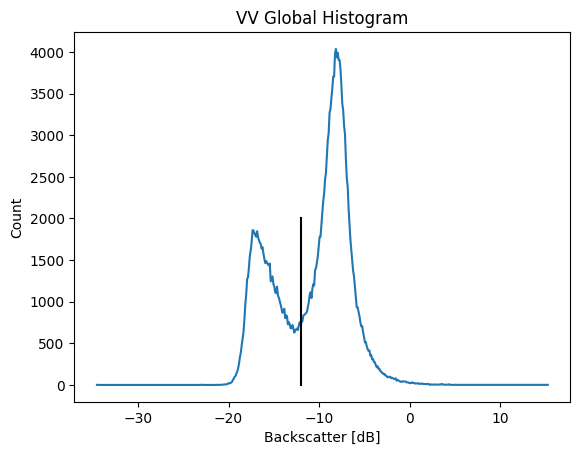

In [11]:
# Set up Otsu thresholding algorithm and run for first image. Code adapted from:
  # K. Markert, G. Donchyts, A. Haag. Available at: https://google-earth-engine.com/Aquatic-and-Hydrological-Applications/Surface-Water-Mapping/
  # Q. Wu. Available at: https://github.com/gee-community/geemap/blob/d8ba370caf712edec4e002653623fec930ec7312/examples/notebooks/otsu.ipynb

# Specify band for Otsu thresholding
band = 'VV'

# Define a reducer to calculate a histogram of values
histogramReducer=ee.Reducer.histogram(300,0.1)

# Reduce all of the image values
globalHistogram = ee.Dictionary(
    s1Image.select(band).reduceRegion(
        reducer=histogramReducer,
        geometry=roi,
        scale=90,
        maxPixels=1e10
    ).get(band)
)

# Otsu algorithm
# Return the DN that maximizes interclass variance.
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)

    indices = ee.List.sequence(1, size)

    # Compute between sum of squares, where each mean partitions the data.

    def func_xxx(i):
        aCounts = counts.slice(0, 0, i)
        aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
        aMeans = means.slice(0, 0, i)
        aMean = (
            aMeans.multiply(aCounts)
            .reduce(ee.Reducer.sum(), [0])
            .get([0])
            .divide(aCount)
        )
        bCount = total.subtract(aCount)
        bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
        return aCount.multiply(aMean.subtract(mean).pow(2)).add(
            bCount.multiply(bMean.subtract(mean).pow(2))
        )

    bss = indices.map(func_xxx)

    # Return the mean value corresponding to the maximum BSS.
    return means.sort(bss).get([-1])

# Print Otsu threshold for QA/QC checking
threshold = otsu(globalHistogram)
#print('threshold', threshold.getInfo())

# Extract out the histogram buckets and counts per bucket.
x =(globalHistogram.get('bucketMeans'))
y = (globalHistogram.get('histogram'))

# Plot histogram with Otsu threshold for QA/QC check
maxCount = 2000 # specify the vertical scale for plotting
plt.plot(x.getInfo(),y.getInfo())
plt.xlabel('Backscatter [dB]')
plt.ylabel('Count')
plt.title('VV Global Histogram')
plt.plot([threshold.getInfo(),threshold.getInfo()],[0,maxCount],'k-')
plt.show()

In [12]:
# Generate and map water masks using simple Otsu threshold on whole tile
# Apply Otsu to image collection and extract masks, using masked threshold buffer
def extract_water(image):
    histogram = image.select('VV').reduceRegion(
        **{
            'reducer': ee.Reducer.histogram(255, 0.1),
            'geometry': roi,
            'scale':90,
            'maxPixels' : 1e10,
            'bestEffort': True,
        }
    )
    threshold = otsu(histogram.get('VV'))
    date = image.date().format("YYYY-MM-dd")
    water = image.select('VV').lt(threshold).selfMask().set({"date":date})
    return water.set({"threshold": threshold})

water_images = s1Collection.map(extract_water)

# Create composite water masks by joining tiles with matching acquisition dates
distinctDates = water_images.distinct('date').sort('date')
filter = ee.Filter.equals(leftField='date', rightField='date')
join = ee.Join.saveAll('date_match')
joinCol = join.apply(distinctDates, water_images, filter)
water_images_mosaic = (ee.ImageCollection(joinCol.map(lambda col: ee.ImageCollection.fromImages(col.get('date_match')).mosaic())).map(lambda image: image.clip(roi)))
dates_mosaic = water_images.distinct('date').aggregate_array('date')

# Prints mosaicked dates for QA/QC check against acquisition dates
dates_mosaic

In [13]:
# Plot first mosaicked water mask and output Otsu threshold list for the image set
Map.addLayer(water_images.first(), {"palette": "blue"}, "first water")
thresholdList = water_images.aggregate_array("threshold").getInfo()
print(thresholdList)

Map

[-12.099565269341007]


Map(bottom=113368.0, center=[23.991271293052666, 89.79400634765626], controls=(WidgetControl(options=['positio…

In [14]:
# Batch output mosaicked water masks
print(water_images_mosaic.aggregate_array('system:index').getInfo())
image_ids = water_images_mosaic.aggregate_array('system:index').getInfo()
for i, image_id in enumerate(image_ids):
  image = ee.Image(water_images_mosaic.filter(ee.Filter.eq('system:index', image_id)).first())
  task = ee.batch.Export.image.toDrive(**{
    'image': image,
    'description': 'Image Export {}'.format(i+1),
    'fileNamePrefix': image_id,
    'folder':'GEE_Output', # Creates a new folder in Google Drive for output
    'scale': 10, # Metres per pixel
    'region': roi,
    'maxPixels': 10000000000000
  })
  task.start()
  print('Started Task: ', i+1)

['S1A_IW_GRDH_1SDV_20160817T235531_20160817T235556_012647_013DA7_714D']
Started Task:  1
